In [ ]:
!pip install librosa imageio imageio-ffmpeg -q

In [ ]:
import os
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import soundfile as sf
import IPython.display as display
import plotly.graph_objects as go
import librosa
import librosa.display

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
import requests

url = "https://osf.io/drjhb/download"
fname = "music.zip"

if not os.path.isfile(fname):
    r = requests.get(url)
    with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
    zipObj.extractall()

In [ ]:
# Inspect an audio file from the dataset.
sample_path = 'Data/genres_original/jazz/jazz.00000.wav'

display.Audio(sample_path)

y: [-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


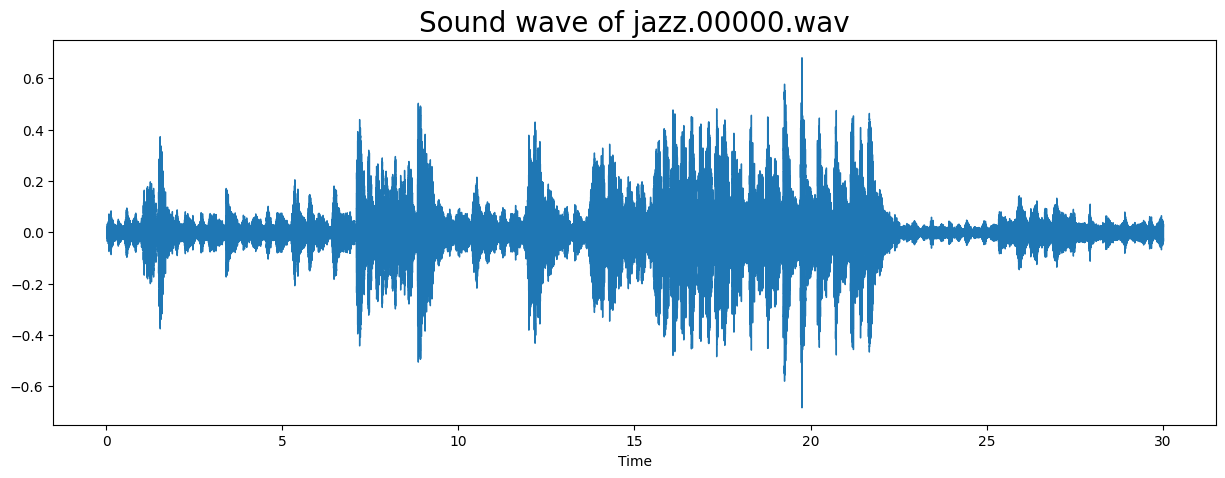

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

### Convert sound wave to spectrogram.


Shape of D object: (1025, 1293)


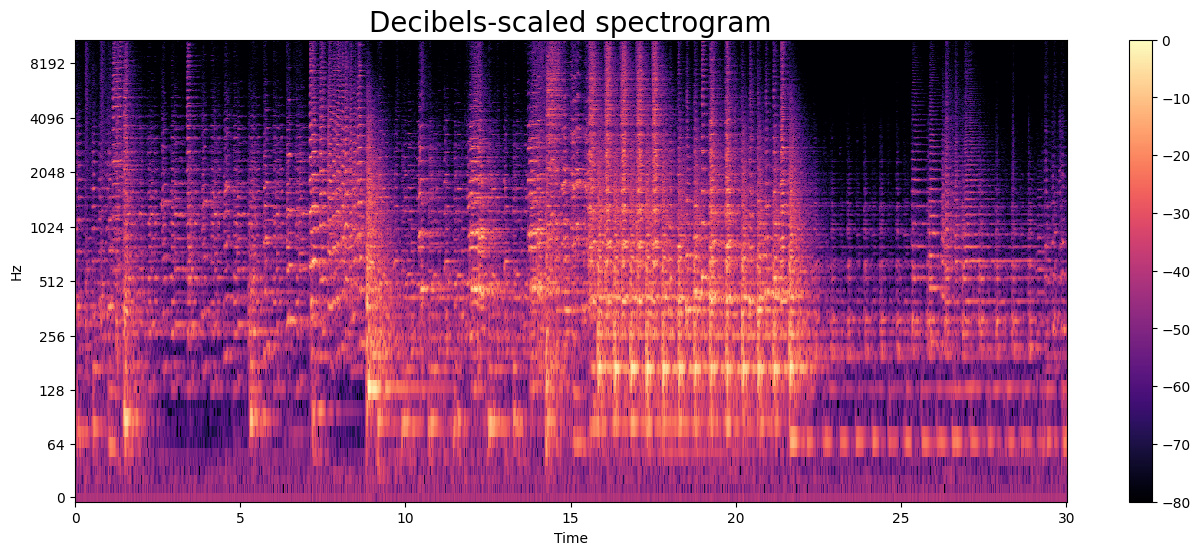

In [ ]:
# Short-time Fourier transform (STFT).
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

# Custom CNN (Melspectrogram version)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_classes =  len(genres)

model = Sequential()
# First Convolutional Block
model.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fifth Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer with L2 regularization
model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.02)))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.02)))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'],
              )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 129, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 129, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,495,114 (9.52 MB)

 Trainable params: 2,495,114 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
validation_generator = GTZANGenerator(X_test, y_test)

hist = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=150,
                verbose=1,
                callbacks=[reduceLROnPlat])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


427/427 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1365 - loss: 12.4253 - val_accuracy: 0.2025 - val_loss: 2.7455 - learning_rate: 0.0010
Epoch 2/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1763 - loss: 2.6146 - val_accuracy: 0.1378 - val_loss: 2.3777 - learning_rate: 0.0010
Epoch 3/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2129 - loss: 2.2211 - val_accuracy: 0.2230 - val_loss: 2.1862 - learning_rate: 0.0010
Epoch 4/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2044 - loss: 2.1596 - val_accuracy: 0.2563 - val_loss: 2.0308 - learning_rate: 0.0010
Epoch 5/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2289 - loss: 2.0751 - val_accuracy: 0.2521 - val_loss: 2.0190 - learning_rate: 0.0010
Epoch 6/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2408 - loss: 2.0866 - val_accuracy: 0.2914 - val_loss: 1.9272 - learning_rate: 0.0010
Epoch 7/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2375 - loss: 2.049

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.022 and val_acc = 0.694


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded labels back to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
genre_names = [name for name, idx in sorted(genres.items(), key=lambda x: x[1])]
print(classification_report(y_true_classes, y_pred_classes, target_names=genre_names))

              precision    recall  f1-score   support

       metal       0.76      0.83      0.79      1170
       disco       0.69      0.77      0.72      1170
   classical       0.87      0.97      0.92      1170
      hiphop       0.94      0.56      0.70      1170
        jazz       0.85      0.72      0.78      1131
     country       0.51      0.81      0.62      1170
         pop       0.61      0.81      0.70      1170
       blues       0.87      0.51      0.65      1170
      reggae       0.80      0.53      0.63      1170
        rock       0.42      0.45      0.43      1170

    accuracy                           0.69     11661
   macro avg       0.73      0.69      0.69     11661
weighted avg       0.73      0.69      0.69     11661

